In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from ssim import ssim
torch.use_deterministic_algorithms(False)


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

# Hyperparameters
lr = 0.0002
batch_size = 32
num_epochs = 20000
device = torch.device("cuda")
train_size = 10000

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders(train_size)

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Initialize BCE loss for Discriminator
criterion_d = nn.BCELoss()

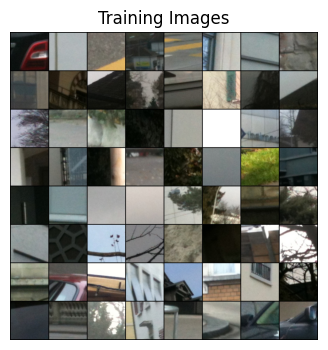

In [2]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [3]:
# Labels
real_labels = torch.ones(32, 1).to(device)
fake_labels = torch.zeros(32, 1).to(device)
ssim_loss = 0
n_epochs = 50  # Number of epochs
torch.use_deterministic_algorithms(False)
for epoch in range(n_epochs):
    for i, (imgs_iphone, imgs_dslr) in enumerate(train_dataloader):
        imgs_iphone = imgs_iphone.to(device)
        imgs_dslr = imgs_dslr.to(device)

        # Adversarial ground truths
        valid = torch.ones(imgs_dslr.size(0), 1, requires_grad=False, device=device)
        fake = torch.zeros(imgs_dslr.size(0), 1, requires_grad=False, device=device)

        # Configure input
        real_imgs = imgs_dslr
        imgs_iphone = imgs_iphone

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(imgs_iphone)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion_d(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion_d(discriminator(real_imgs), valid)
        fake_loss = criterion_d(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        # Print the epoch and loss
        print(f'Epoch: {epoch}, Loss: {d_loss.item()}')


Epoch: 0, Loss: 0.694091796875
Epoch: 0, Loss: 0.851087749004364
Epoch: 0, Loss: 0.6500595808029175
Epoch: 0, Loss: 0.7202149629592896
Epoch: 0, Loss: 0.6962453722953796
Epoch: 0, Loss: 0.5753740668296814
Epoch: 0, Loss: 0.533611536026001
Epoch: 0, Loss: 0.5287811756134033
Epoch: 0, Loss: 0.49090316891670227
Epoch: 0, Loss: 0.43412506580352783
Epoch: 0, Loss: 0.36607134342193604
Epoch: 0, Loss: 0.31894388794898987
Epoch: 0, Loss: 0.28536128997802734
Epoch: 0, Loss: 0.2599928379058838
Epoch: 0, Loss: 0.22618673741817474
Epoch: 0, Loss: 0.1873767375946045
Epoch: 0, Loss: 0.15345638990402222
Epoch: 0, Loss: 0.12784738838672638
Epoch: 0, Loss: 0.10643991082906723
Epoch: 0, Loss: 0.09014725685119629
Epoch: 0, Loss: 0.07770071923732758
Epoch: 0, Loss: 0.0622812956571579
Epoch: 0, Loss: 0.049012694507837296
Epoch: 0, Loss: 0.038273781538009644
Epoch: 0, Loss: 0.032613418996334076
Epoch: 0, Loss: 0.029141627252101898
Epoch: 0, Loss: 0.04728826880455017
Epoch: 0, Loss: 0.07814670354127884
Epoch

In [4]:
# Save the model
torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'loss': g_loss,
}, f"generator_epoch_{epoch}.pth")
